In [9]:
#pip install seaborn
#pip install openpyxl

In [10]:
#pip install scikit-learn

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


**Upload DataFrames**

In [12]:
# DO NOT CHANGE THESE DATAFRAMES
# CREATE COPIES
df_threats = pd.read_csv('df_threats_ss.csv', parse_dates=True)
df_net_crime = pd.read_csv('LossFromNetCrime.csv')
df_world = pd.read_csv('world-data-2023.csv', index_col = 'Country')

#### EU Country Codes Dictionary (Hide Cell)

In [13]:
eu_country_codes = {
    "PT": "Portugal", "AT": "Austria", "RO": "Romania", "BE": "Belgium",
    "BG": "Bulgaria", "SE": "Sweden", "SI": "Slovenia", "SK": "Slovakia",
    "CY": "Cyprus", "CZ": "Czech Republic", "DE": "Germany", "DK": "Denmark",
    "EE": "Estonia", "ES": "Spain", "FI": "Finland", "FR": "France",
    "GR": "Greece", "HR": "Croatia", "HU": "Hungary", "IE": "Ireland",
    "IT": "Italy", "LT": "Lithuania", "LU": "Luxembourg", "LV": "Latvia",
    "MT": "Malta", "NL": "Netherlands", "PL": "Poland", "EU": "Europe region"
}

### Update the dataframes to include EU countries only 

In [14]:
df_threats = df_threats[df_threats['Receiver country'].isin(eu_country_codes.values())]
df_net_crime = df_net_crime[df_net_crime['Country'].isin(eu_country_codes.keys())]

# works differently for index column
valid_indices = df_world.index.intersection(eu_country_codes.values())
df_world = df_world.loc[valid_indices]

In [15]:
# final output dataFrame for this cell = cntry_loss

cntry_loss = df_net_crime.copy() #copy df
cntry_loss = cntry_loss.rename(columns = {'Country' :'Country Code'}).sort_values(by = 'Country Code') # rename column and sort
#print(cntry_loss.loc[103])
#print(cntry_loss.shape)
cntry_loss = cntry_loss.dropna() # delete the nan columns
#cntry_loss = cntry_loss.drop(axis = 0, index = 103) # delete the nan column
#print(cntry_loss.shape)

column = cntry_loss['Country Code'] # define column variable

# create empty lists
country_col = []
country_id = []
# create a 3 digit country ID
value = 100

for i in column:
    #print(country_codes[i])
    # from list append
    country_col.append(country_codes[i])
    value += 1
    country_id.append((value))

# create new columns
cntry_loss.insert(loc = 1, column = 'Country', value = country_col)
cntry_loss.insert(loc = 1, column = 'Country ID', value = country_id)
df_loss = cntry_loss.reset_index().copy()
df_loss = df_loss.drop('index', axis =1)

# Section 1 - Cyber Crime Losses & Complaints – Guided Analysis

Welcome! This notebook is designed for **non‑technical and non‑coding users** who need to explore a cyber crime dataset and prepare results for Power BI.  \
We will walk through each step, explain what the code does in plain language, and export tables to CSV files so you can create charts in Power BI without writing any code yourself.  \
If a plot would normally appear in Python, we instead save the underlying data for Power BI.  \
At the end you will have several CSV files ready to import into Power BI to create your own charts.

## 1. Load and prepare the data

In this section we will:

1. Import the Python packages we need.
2. Create a folder to store our output files (so everything is in one place).
3. Read the cyber crime dataset from `LossFromNetCrime.csv`.
4. Clean the data by filling missing country names and converting numeric columns to numbers.
5. Define the list of years (2019–2024) we will analyse.

Everything is commented so you can follow along even if you have never coded before.

In [16]:
# 1.1 Create an output folder if it does not already exist.
# All of our CSV files will be saved here.
os.makedirs('Code_Output', exist_ok=True)

# 1.2 Load the df_loss dataframe
#df_loss = df_net_crime.copy()

# 1.3 Replace any missing country names with 'Unknown'.
# This prevents errors when sorting or grouping.
df_loss['Country'] = df_loss['Country'].fillna('Unknown')

# 1.4 Convert all columns except 'Country' to numbers.
# Sometimes numbers are stored as text; this forces them to numeric so we can add and average them.
numeric_cols = [c for c in df_loss.columns if c not in ['Country', 'Country Code']]

df_loss[numeric_cols] = df_loss[numeric_cols].apply(pd.to_numeric, errors='coerce')

# 1.5 Define the years we will analyse.
years = [2019, 2020, 2021, 2022, 2023, 2024]

# 1.6 Display the first few rows to verify the data loaded correctly.
df_loss.head()

,Country Code,Country ID,Country,2019_Complaints,2019_Losses,2020_Complaints,2020_Losses,2021_Complaints,2021_Losses,2022_Complaints,2022_Losses,2023_Complaints,2023_Losses,2024_Complaints,2024_Losses
0,AT,101,Austria,6942,47306368,10963,41464758,15412,116199865,11239,133170619,9614,163158856,14534,145551079
1,BE,102,Belgium,6275,61314011,10620,81868291,11842,142566044,10859,217821448,11848,184239517,12375,303148050
2,BG,103,Bulgaria,14189,118129647,26712,111207806,24968,248788813,23525,338814414,26404,443783119,24208,522143452
3,CY,104,Cyprus,999,5686522,1706,6853488,1762,12133741,1723,17339298,2345,19199921,1838,19483205
4,CZ,105,Czech Republic,30211,172991200,47442,212529097,68328,431356435,49178,514944367,60855,600351173,60358,718180351


## 2. Totals by year and changes

To understand the overall trend, we need to know how many complaints and how much money was lost across **all countries** each year.

We will:

- Sum complaints and losses for each year.
- Compute the change from one year to the next (this shows whether things are getting better or worse).
- Save the results to a CSV file for Power BI (`totals.csv`).
- Display the table in the notebook for reference.

In [17]:
# 2.1 Calculate total complaints and losses for each year across all countries
totals = []
for year in years:
    total_complaints = df_loss[f'{year}_Complaints'].sum()
    total_losses = df_loss[f'{year}_Losses'].sum()
    totals.append({
        'Year': year,
        'Total_Complaints': total_complaints,
        'Total_Losses': total_losses
    })

# 2.2 Convert the list of totals to a DataFrame
totals_df = pd.DataFrame(totals)

# 2.3 Compute year‑over‑year changes
totals_df['Complaints_Change'] = totals_df['Total_Complaints'].diff()
totals_df['Losses_Change'] = totals_df['Total_Losses'].diff()

# 2.4 Save the totals and changes to CSV for Power BI
totals_df.to_csv('Code_Output/totals.csv', index=False)

# 2.5 Display the totals table
totals_df

,Year,Total_Complaints,Total_Losses,Complaints_Change,Losses_Change
0,2019,592135,5806561305,NaN,NaN
1,2020,926298,7593895214,334163.0,1.787334e+09
2,2021,1023987,11503890534,97689.0,3.909995e+09
3,2022,991992,16708820739,-31995.0,5.204930e+09
4,2023,1112025,21206120165,120033.0,4.497299e+09
5,2024,1035712,23799224049,-76313.0,2.593104e+09


#### Plot for Testing Purposes

In [18]:
#plt.plot(totals_df['Year'], totals_df['Total_Complaints'])
#plt.plot(totals_df['Year'], totals_df['Total_Losses'])

## 3. Top countries by complaints and losses (per year)

Power BI visualisations often focus on the top performers or worst offenders. We will identify the **top 5 countries** for each year based on both complaints and losses. Instead of plotting the results here, we build tidy tables for Power BI:

- `top5_complaints_chart_data.csv`: Each row contains the year, country, and complaints (in millions).
- `top5_losses_chart_data.csv`: Each row contains the year, country, and losses (in billions).

These files allow you to create bar charts in Power BI showing the top countries year by year.

In [19]:
# 3.1 Build the data for top 5 complaints per year
complaint_rows = []
for year in years:
    col_name = f'{year}_Complaints'
    # Sort the countries by complaints for this year and take the top 5
    top5 = df_loss.sort_values(by=col_name, ascending=False).head(5)
    for country, value in zip(top5['Country'], top5[col_name]):
        complaint_rows.append({
            'Year': year,
            'Country': country,
            'Complaints_Millions': value / 1_000_000
        })

complaint_chart_df = pd.DataFrame(complaint_rows)

# 3.2 Save the data to CSV
complaint_chart_df.to_csv('Code_Output/top5_complaints_chart_data.csv', index=False)

# 3.3 Display the first few rows for reference
complaint_chart_df.head()

,Year,Country,Complaints_Millions
0,2019,France,0.160810
1,2019,Germany,0.095136
2,2019,Netherlands,0.049692
3,2019,Sweden,0.043233
4,2019,Italy,0.042362


#### Testing Purposes Table (Hide Cell)

In [20]:
table = pd.DataFrame()

table['2019'] = list(complaint_chart_df[complaint_chart_df['Year'] == 2019]['Country'])
table['2020'] = list(complaint_chart_df[complaint_chart_df['Year'] == 2020]['Country'])
table['2021'] = list(complaint_chart_df[complaint_chart_df['Year'] == 2021]['Country'])
table['2022'] = list(complaint_chart_df[complaint_chart_df['Year'] == 2022]['Country'])
table['2023'] = list(complaint_chart_df[complaint_chart_df['Year'] == 2023]['Country'])
table['2024'] = list(complaint_chart_df[complaint_chart_df['Year'] == 2024]['Country'])

complaint_chart_df

table

,2019,2020,2021,2022,2023,2024
0,France,France,France,Germany,France,France
1,Germany,Germany,Germany,France,Germany,Germany
2,Netherlands,Netherlands,Italy,Sweden,Italy,Netherlands
3,Sweden,Italy,Netherlands,Netherlands,Netherlands,Italy
4,Italy,Sweden,Sweden,Italy,Sweden,Spain


In [21]:
# 3.4 Build the data for top 5 losses per year
loss_rows = []
for year in years:
    col_name = f'{year}_Losses'
    top5 = df_loss.sort_values(by=col_name, ascending=False).head(5)
    for country, value in zip(top5['Country'], top5[col_name]):
        loss_rows.append({
            'Year': year,
            'Country': country,
            'Losses_Billions': value / 1_000_000_000
        })

loss_chart_df = pd.DataFrame(loss_rows)

# 3.5 Save to CSV
loss_chart_df.to_csv('Code_Output/top5_losses_chart_data.csv', index=False)

# 3.6 Display the first few rows
loss_chart_df.head()

,Year,Country,Losses_Billions
0,2019,Germany,1.559416
1,2019,France,0.967759
2,2019,Netherlands,0.572305
3,2019,Poland,0.390366
4,2019,Spain,0.334886


## 5. Linear Regression - Least Squares Fit 
Fits a line by calculating the sums of differences of values from the mean

In [22]:
years = [2019, 2020, 2021, 2022, 2023, 2024]
# X is a np.array of years in the shape LinearRegression can read
# np.array([[]])
X = np.array(years).reshape(-1, 1)  # shape (6,1)

# start with empty lists 
pred_loss_list = []
pred_comp_list = []
err_loss_list = []
err_comp_list =[]

#for each country in the DataFrame
for country in df_loss['Country']:
    
    # Isolate the losses and complaints into a separate array 
    y_losses     = np.array([df_loss.loc[df_loss['Country'] == country, f'{yr}_Losses'].values[0]     for yr in years])
    y_complaints = np.array([df_loss.loc[df_loss['Country'] == country, f'{yr}_Complaints'].values[0] for yr in years])
    
    # Fit ordinary least squares line 
    lr_loss = LinearRegression().fit(X, y_losses)
    lr_comp = LinearRegression().fit(X, y_complaints)
    
    # Calculate mean square error
    err_loss = np.sqrt(np.sum((lr_loss.predict(X) - y_losses)**2)/(len(y_losses) - 2))
    err_comp = np.sqrt(np.sum((lr_comp.predict(X) - y_complaints)**2)/(len(y_complaints)- 2))
    #save to lists
    err_loss_list.append(err_loss)
    err_comp_list.append(err_comp)
    
    # Prediction for 2025: 
    pred_loss = lr_loss.predict(np.array([[2025]]))[0]
    pred_comp = lr_comp.predict(np.array([[2025]]))[0]
    #save to lists
    pred_loss_list.append(pred_loss)
    pred_comp_list.append(pred_comp)

#create new dataframe
df_pred = df_loss.drop('Country ID', axis = 1).copy()
df_pred[f'{2025}_Losses'] = pred_loss_list
df_pred[f'{2025}_Complaints'] = pred_comp_list

#create new dataframe
df_err = df_pred.copy()
df_err[numeric_cols] = 0
df_err[f'{2025}_Losses'] = err_loss_list
df_err[f'{2025}_Complaints'] = err_comp_list
df_err = df_err.drop('Country ID', axis = 1)

#save
df_pred.to_csv('Prediction.csv')
df_err.to_csv('Errors.csv')

#### Testing purposes

In [67]:
# create new df with predicted values and errors only
df_pred_err = pd.DataFrame()
df_pred_err['Country'] = df_pred['Country']
df_pred_err['Losses'] = pred_loss_list
df_pred_err['Loss_Err'] = err_loss_list

# calculate the percantege of the error of the value 
percentage = []
for i in range(len(err_loss_list)):
    percentage.append(100*err_loss_list[i]/pred_loss_list[i])
df_pred_err['Err_Percent'] = percentage

df_pred_cutoff = df_pred_err[df_pred_err['Err_Percent'] < 20]

print(df_pred_err.size, df_pred_cutoff.size)

legend_countr_loss = df_pred_err.sort_values(by= 'Losses', ascending = False)

108 108


In [69]:
# create new df with predicted values and errors only
df_pred_err = pd.DataFrame()
df_pred_err['Country'] = df_pred['Country']
df_pred_err['Complaints'] = pred_comp_list
df_pred_err['Comp_Err'] = err_comp_list

# calculate the percantege of the error of the value 
percentage = []
for i in range(len(err_comp_list)):
    percentage.append(100*err_comp_list[i]/pred_comp_list[i])
df_pred_err['Err_Percent'] = percentage

df_pred_cutoff = df_pred_err[df_pred_err['Err_Percent'] < 30]

print(df_pred_err.size, df_pred_cutoff.size)
df_pred_cutoff

legend_countr_comp = df_pred_err.sort_values(by= 'Complaints', ascending = False)

108 108


## 6. Tidy Up

In [25]:
years = [2019, 2020, 2021, 2022, 2023, 2024, 2025]
#empty lists
rows_loss = []
rows_comp = []
for country in df_pred['Country']: 
    
    # get values
    y_losses = [df_pred.loc[df_pred['Country'] == country, f'{year}_Losses'].values[0] for year in years]
    y_complaints = [df_pred.loc[df_pred['Country'] == country, f'{yr}_Complaints'].values[0] for yr in years]

    for val, year_val in zip(y_losses, years):
        rows_loss.append({
            'Country': country,
            'Year': year_val,
            'Losses_USD': val
        })
    for val, year_val in zip(y_complaints, years):
        rows_comp.append({
            'Country': country,
            'Year': year_val,
            'Complaints': val
        })    
df_loss_pred_save = pd.DataFrame(rows_loss)
df_comp_pred_save = pd.DataFrame(rows_comp)

df_loss_pred_save.to_csv('Pred_Loss.csv')
df_comp_pred_save.to_csv('Pred_Comp.csv')

In [26]:
years = [2019, 2020, 2021, 2022, 2023, 2024, 2025]
#empty lists
rows_loss = []
rows_comp = []

for country in df_err['Country']: 
    
    # get values
    y_losses = [df_err.loc[df_err['Country'] == country, f'{year}_Losses'].values[0] for year in years]
    y_complaints = [df_err.loc[df_err['Country'] == country, f'{yr}_Complaints'].values[0] for yr in years]

    for val, year_val in zip(y_losses, years):
        rows_loss.append({
            'Country': country,
            'Year': year_val,
            'Losses_USD': val
        })
    for val, year_val in zip(y_complaints, years):
        rows_comp.append({
            'Country': country,
            'Year': year_val,
            'Complaints': val
        })    
df_loss_err_save = pd.DataFrame(rows_loss)
df_comp_err_save = pd.DataFrame(rows_comp)

df_loss_err_save.to_csv('Errors_Loss.csv')
df_comp_err_save.to_csv('Errors_Comp.csv')

In [27]:
df_loss_pred_save

,Country,Year,Losses_USD
0,Austria,2019,4.730637e+07
1,Austria,2020,4.146476e+07
2,Austria,2021,1.161999e+08
3,Austria,2022,1.331706e+08
4,Austria,2023,1.631589e+08
...,...,...,...
184,Slovakia,2021,2.344171e+07
185,Slovakia,2022,4.587429e+07
186,Slovakia,2023,6.995167e+07
187,Slovakia,2024,8.007493e+07


In [28]:
df_loss_err_save

,Country,Year,Losses_USD
0,Austria,2019,0.000000e+00
1,Austria,2020,0.000000e+00
2,Austria,2021,0.000000e+00
3,Austria,2022,0.000000e+00
4,Austria,2023,0.000000e+00
...,...,...,...
184,Slovakia,2021,0.000000e+00
185,Slovakia,2022,0.000000e+00
186,Slovakia,2023,0.000000e+00
187,Slovakia,2024,0.000000e+00


#### Testing Purposes

<ErrorbarContainer object of 3 artists>

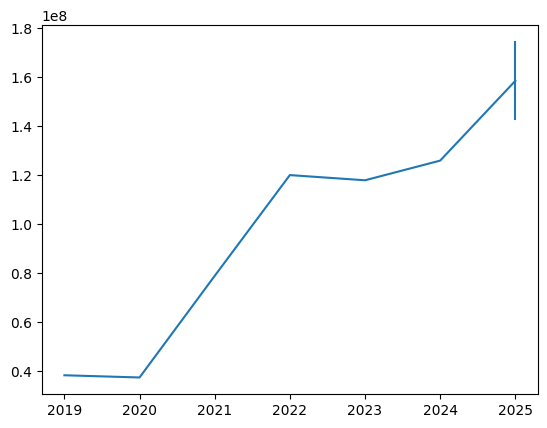

In [29]:
# plot single country 
country = 'Denmark'

data = df_loss_pred_save[df_loss_pred_save['Country'] == country]['Losses_USD']
x = df_loss_pred_save[df_loss_pred_save['Country'] == country]['Year']
errors = df_loss_err_save[df_loss_err_save['Country'] == country]['Losses_USD']

#plt.plot(x, data)
plt.errorbar(x,data, yerr= errors)

#### All Countries Losses

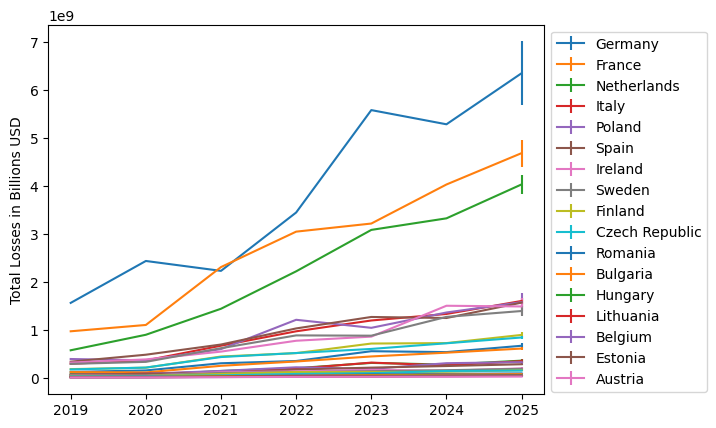

In [76]:

# plot set of countries
country_list = legend_countr_loss['Country']

for country in country_list:
    data = df_loss_pred_save[df_loss_pred_save['Country'] == country]['Losses_USD']
    x = df_loss_pred_save[df_loss_pred_save['Country'] == country]['Year']
    errors = df_loss_err_save[df_loss_err_save['Country'] == country]['Losses_USD']
    
    #plt.plot(x, data)
    plt.errorbar(x,data, yerr= errors)
plt.ylabel('Total Losses in Billions USD')
plt.legend(legend_countr_loss.reset_index().loc[:16]['Country'], loc='upper left', bbox_to_anchor=(1, 1))

#### Top 5 countries

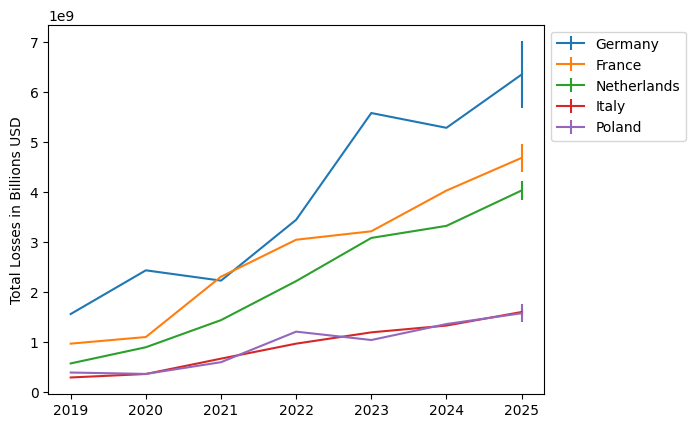

In [71]:

# plot set of countries
country_list = legend_countr_loss.reset_index().loc[:4]['Country']

for country in country_list:
    data = df_loss_pred_save[df_loss_pred_save['Country'] == country]['Losses_USD']
    x = df_loss_pred_save[df_loss_pred_save['Country'] == country]['Year']
    errors = df_loss_err_save[df_loss_err_save['Country'] == country]['Losses_USD']
    
    #plt.plot(x, data)
    plt.errorbar(x,data, yerr= errors)
plt.ylabel('Total Losses in Billions USD')
plt.legend(legend_countr_loss.reset_index().loc[:16]['Country'], loc='upper left', bbox_to_anchor=(1, 1))

#### ALl Countries Complaints

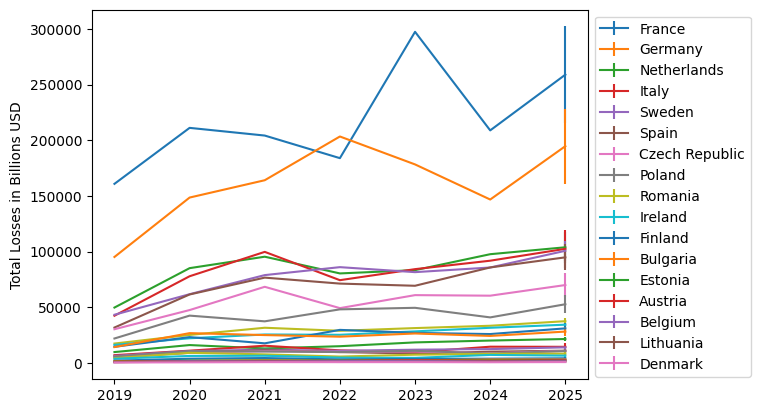

In [75]:

# plot set of countries
country_list = legend_countr_comp['Country']

for country in country_list:
    data = df_comp_pred_save[df_comp_pred_save['Country'] == country]['Complaints']
    x = df_comp_pred_save[df_comp_pred_save['Country'] == country]['Year']
    errors = df_comp_err_save[df_comp_err_save['Country'] == country]['Complaints']
    
    #plt.plot(x, data)
    plt.errorbar(x,data, yerr= errors)
plt.ylabel('Total Losses in Billions USD')
plt.legend(legend_countr_comp.reset_index().loc[:16]['Country'], loc='upper left', bbox_to_anchor=(1, 1))

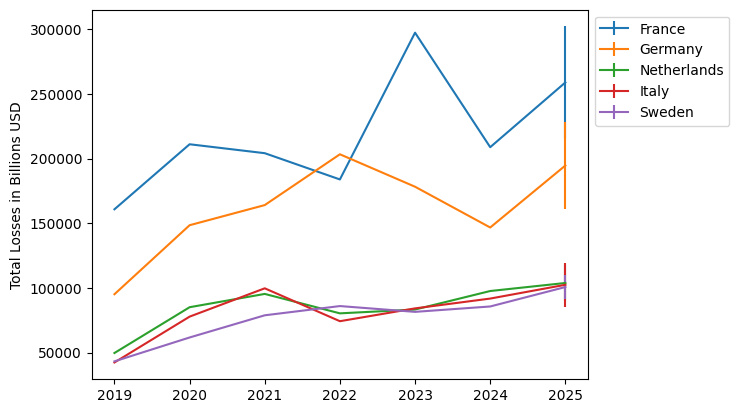

In [74]:

# plot set of countries
country_list = legend_countr_comp.reset_index().loc[:4]['Country']

for country in country_list:
    data = df_comp_pred_save[df_comp_pred_save['Country'] == country]['Complaints']
    x = df_comp_pred_save[df_comp_pred_save['Country'] == country]['Year']
    errors = df_comp_err_save[df_comp_err_save['Country'] == country]['Complaints']
    # Add the error band
    plt.errorbar(x,data, yerr= errors)

   # plt.fill_between(x, data - errors, data + errors, color='blue', alpha=0.2)

plt.ylabel('Total Losses in Billions USD')
plt.legend(legend_countr_comp.reset_index().loc[:16]['Country'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


## 7. Summary and next steps

We have now:

- Loaded and cleaned the cyber crime dataset.
- Calculated annual totals and changes.
- Identified top countries for complaints and losses.
- Evaluated the correlation between complaints and losses.
- Predicted 2025 losses using the average change.
- Prepared a tidy dataset for plotting actual vs predicted losses.

All tables have been saved to the `Code_Output` folder as CSV files.  \
We can now import these files into Power BI to create bar charts, line charts, and other visualisations.  \
In Power BI remember to set the appropriate data types (e.g., `Year` as a whole number) and choose **Sum** for numeric fields.

# Section 2 - Analysis of cyber attacks

## Cyber Incidents Dataset — Notebook Overview

This notebook uses a curated subset of a Zenodo-hosted catalog of cyber incidents. Each row represents a single incident targeting an entity in a specific country, with attributes describing when it started, who targeted whom, how it was carried out, what was impacted, and whether it may have breached international law. The data supports exploratory analysis of timelines, geographies, attack categories, and outcomes (e.g., political responses, intelligence impacts).

**Column Dictionary**

* **Start date** — The calendar date on which the incident began,
suitable for parsing to datetime.

* **Incident type** — A categorical label describing the specific mode of attack (e.g., DDoS, intrusion, malware, defacement, phishing).

* **Receiver country** — The primary country that was targeted or affected by the incident.

* **Category** — A higher-level grouping of the incident (e.g., espionage, disruption, influence, sabotage) used for broader aggregation.

* **Initiator country** — The country attributed as the origin/sponsor of the incident (may be Unknown or disputed).

* **Political responses** — Recorded official or public reactions to the incident (e.g., sanctions, diplomatic statements, expulsions), often as free text and potentially multi-valued.

* **MITRE Impact** — The effect of the incident aligned to MITRE ATT&CK “Impact” outcomes (e.g., service disruption, data manipulation/destruction, resource hijacking).

* **Intelligence impact** — A qualitative assessment of information compromise or manipulation  

  *Scale 1–5:*

  1 — no data breach/exfiltration, manipulation, or leaking;

  2 — minor data breach/exfiltration (no sensitive/critical information), with no manipulation or leaking;

  3 — data manipulation (e.g., deletion/altering) or a major data breach/exfiltration, but without leaking/manipulation;

  4 — minor data breach/exfiltration with manipulation and/or leaking;

  5 — major data breach/exfiltration of sensitive/critical information and data manipulation and/or leaking.

* **International Law Breach Indicator** — A binary/ordinal flag indicating whether the incident was assessed as breaching international law (e.g., Yes/No or 1/0).

* **Year of incident** — The four-digit year associated with the incident (usually derived from Start date) for convenient time-based grouping.

In [31]:
#df_threats.head()

### Category vs Intelligence Impact

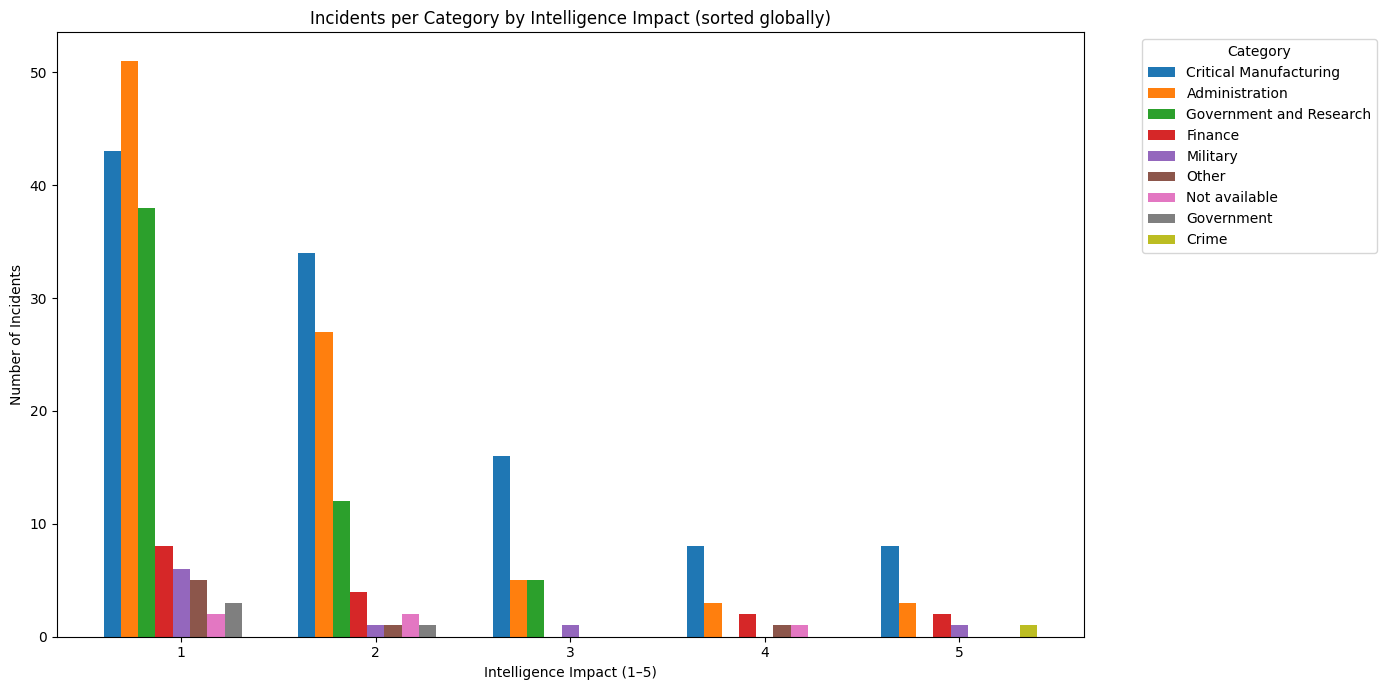

In [32]:
impact_counts = df_threats.groupby(["Intelligence impact", "Category"])["Incident type"].count().unstack(fill_value=0)
impact_counts = impact_counts[impact_counts.sum(axis=0).sort_values(ascending=False).index]

x = np.arange(len(impact_counts.index))
width = 0.8 / len(impact_counts.columns)

plt.figure(figsize=(14,7))
for i, category in enumerate(impact_counts.columns):
    plt.bar(x + i*width, impact_counts[category], width=width, label=category)

plt.xticks(x + width*(len(impact_counts.columns)-1)/2, impact_counts.index)
plt.xlabel("Intelligence Impact (1–5)")
plt.ylabel("Number of Incidents")
plt.title("Incidents per Category by Intelligence Impact (sorted globally)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Most vulnerable sector (by number of incidents)

<Figure size 1400x700 with 0 Axes>

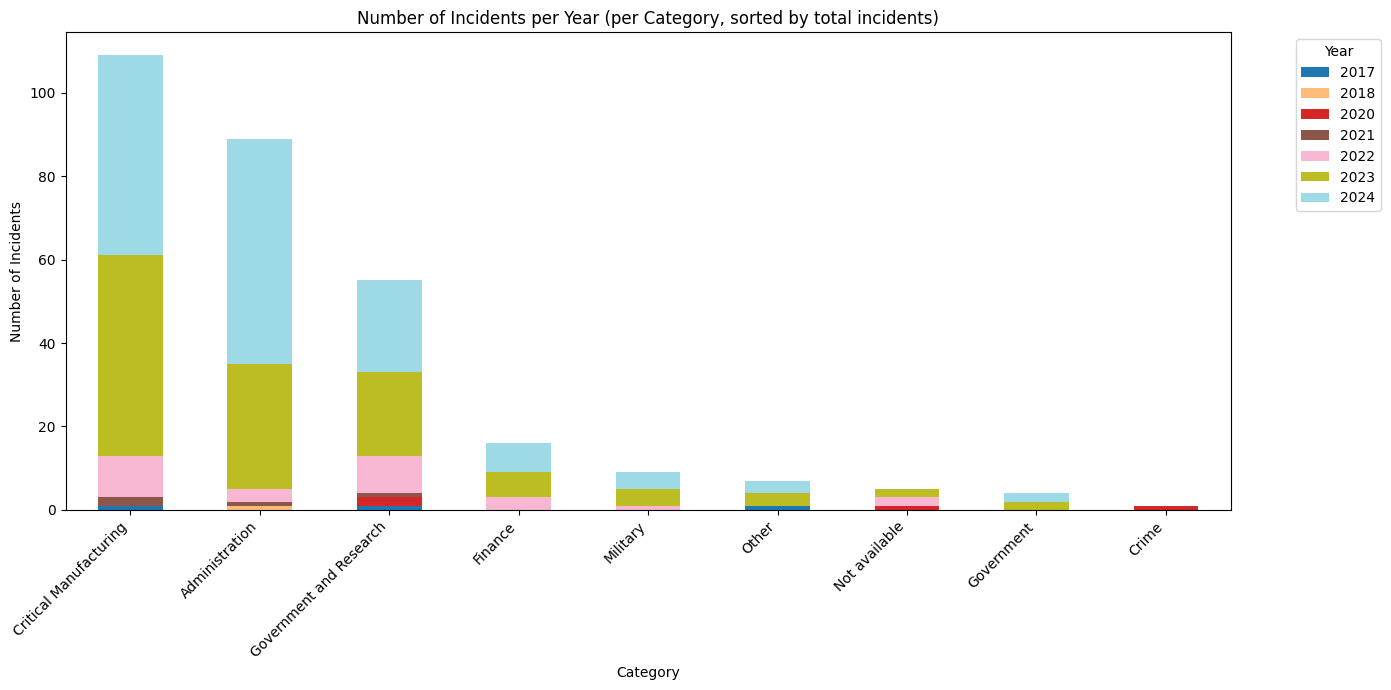

In [33]:
df_threats["Start date"] = pd.to_datetime(df_threats["Start date"], errors="coerce")
df_threats["Year"] = df_threats["Start date"].dt.year

category_counts_per_year = df_threats.groupby(["Category", "Year"])["Incident type"].count().unstack(fill_value=0)

category_counts_per_year = category_counts_per_year.loc[category_counts_per_year.sum(axis=1).sort_values(ascending=False).index]

#new_pl = category_counts_per_year[category_counts_per_year['Year'] > 2021]

plt.figure(figsize=(14,7))
category_counts_per_year.plot(kind="bar", stacked=True, figsize=(14,7), colormap="tab20")
plt.title("Number of Incidents per Year (per Category, sorted by total incidents)")
plt.xlabel("Category")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

max_per_category = category_counts_per_year.idxmax(axis=1)
counts_per_category = category_counts_per_year.max(axis=1)

### Incident type vs MITRE Impact

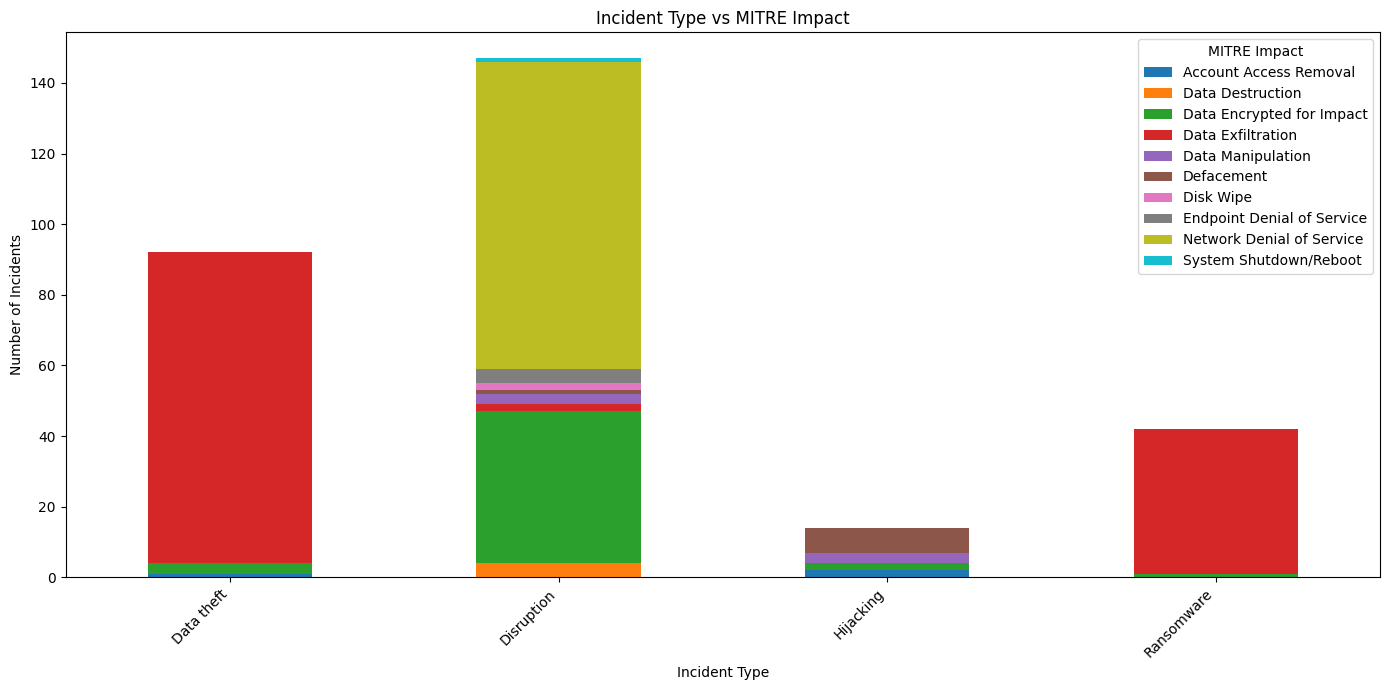

In [34]:
incident_mitre = df_threats.groupby(["Incident type", "MITRE Impact"])["Start date"].count().unstack(fill_value=0)

incident_mitre.plot(kind="bar", stacked=True, figsize=(14,7))
plt.title("Incident Type vs MITRE Impact")
plt.ylabel("Number of Incidents")
plt.xlabel("Incident Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Incident type vs Year (time trends)

#### Comment (Hide):

For EU data:

over span of 2017-2024 and span of 2022-2024 the distribution stays the same

However,

for world data: 

over span of 2017-2024 the most common type is Data theft

over span of 2022-2024 the most common type is Disruption

#### Plot

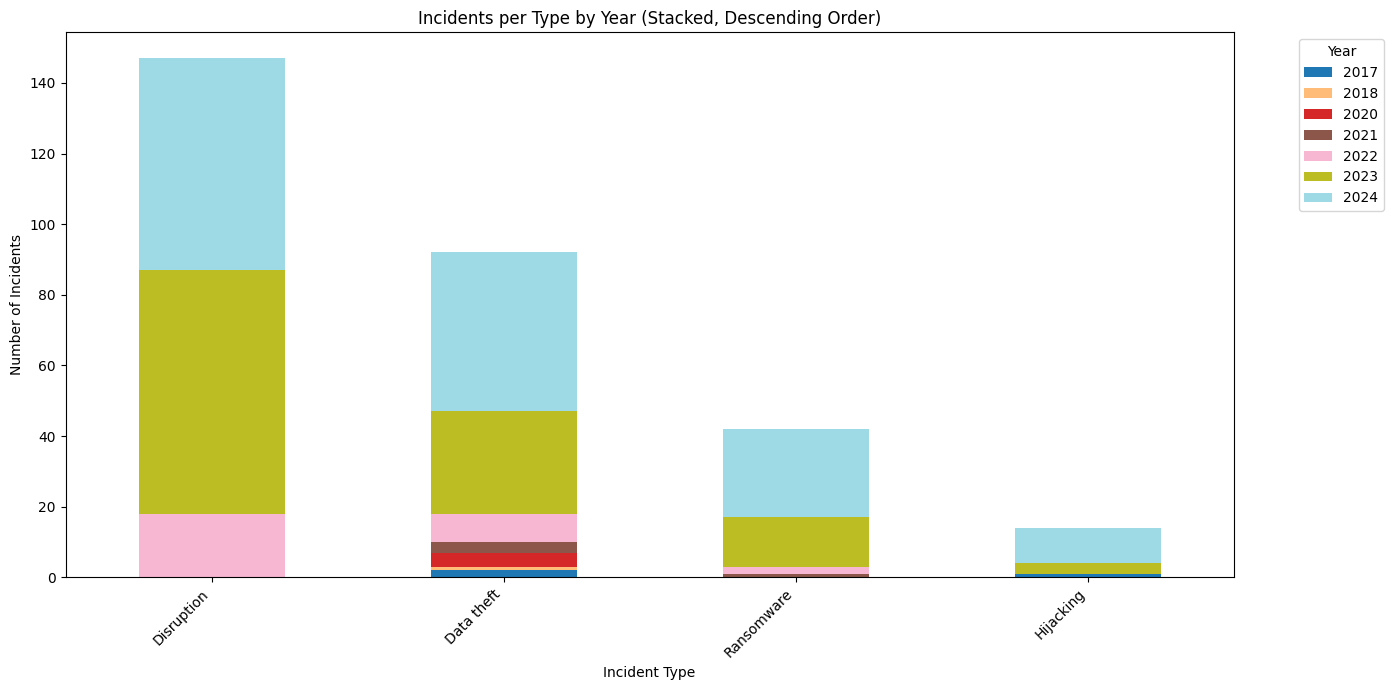

In [35]:
df_threats["Year"] = pd.to_datetime(df_threats["Start date"], errors="coerce").dt.year

# Group by Incident type and Year
incident_type_year = df_threats.groupby(["Incident type", "Year"])["Start date"].count().unstack(fill_value=0)

# Sort incident types by total number of incidents (descending)
incident_type_year = incident_type_year.loc[incident_type_year.sum(axis=1).sort_values(ascending=False).index]

# ~~~ This line is related to the comment
new_plot = incident_type_year#[[2024, 2023, 2022]]#.transpose()

# Plot stacked bar chart
new_plot.plot(
    kind="bar",
    stacked=True,
    figsize=(14,7),
    colormap="tab20"
)

plt.title("Incidents per Type by Year (Stacked, Descending Order)")
plt.xlabel("Incident Type")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Section 3 - Combining Data sets

### Country Codes Hide Cell

In [36]:
country_codes = {
    "PR": "Puerto Rico", "PS": "Palestine", "PT": "Portugal", "PY": "Paraguay",
    "AE": "United Arab Emirates", "AF": "Afghanistan", "AL": "Albania", "AM": "Armenia",
    "AO": "Angola", "AR": "Argentina", "AT": "Austria", "AU": "Australia",
    "AZ": "Azerbaijan", "RO": "Romania", "BA": "Bosnia and Herzegovina", "RS": "Serbia",
    "BD": "Bangladesh", "RU": "Russia", "BE": "Belgium", "BG": "Bulgaria",
    "BH": "Bahrain", "SA": "Saudi Arabia", "BR": "Brazil", "SC": "Seychelles",
    "SE": "Sweden", "SG": "Singapore", "SI": "Slovenia", "BY": "Belarus",
    "SK": "Slovakia", "BZ": "Belize", "CA": "Canada", "SV": "El Salvador",
    "CH": "Switzerland", "SZ": "Eswatini", "CL": "Chile", "CN": "China",
    "CO": "Colombia", "CR": "Costa Rica", "TH": "Thailand", "CY": "Cyprus",
    "CZ": "Czech Republic", "TR": "Turkey", "DE": "Germany", "TW": "Taiwan",
    "TZ": "Tanzania", "DK": "Denmark", "DO": "Dominican Republic", "UA": "Ukraine",
    "UG": "Uganda", "US": "United States", "EC": "Ecuador", "EE": "Estonia",
    "EG": "Egypt", "UZ": "Uzbekistan", "ES": "Spain", "VE": "Venezuela",
    "VG": "British Virgin Islands", "VN": "Vietnam", "FI": "Finland", "FR": "France",
    "GB": "United Kingdom", "GE": "Georgia", "GH": "Ghana", "GN": "Guinea",
    "GR": "Greece", "GT": "Guatemala", "HK": "Hong Kong", "HN": "Honduras",
    "HR": "Croatia", "YE": "Yemen", "HU": "Hungary", "ID": "Indonesia",
    "IE": "Ireland", "IL": "Israel", "IN": "India", "ZA": "South Africa",
    "IQ": "Iraq", "IR": "Iran", "IS": "Iceland", "IT": "Italy",
    "ZW": "Zimbabwe", "JO": "Jordan", "JP": "Japan", "KE": "Kenya",
    "KG": "Kyrgyzstan", "KH": "Cambodia", "KN": "Saint Kitts and Nevis", "KR": "South Korea",
    "KZ": "Kazakhstan", "LB": "Lebanon", "LK": "Sri Lanka", "LT": "Lithuania",
    "LU": "Luxembourg", "LV": "Latvia", "LY": "Libya", "MD": "Moldova",
    "MM": "Myanmar", "MN": "Mongolia", "MT": "Malta", "MV": "Maldives",
    "MX": "Mexico", "MY": "Malaysia", "MZ": "Mozambique", "NG": "Nigeria",
    "NI": "Nicaragua", "NL": "Netherlands", "NO": "Norway", "NP": "Nepal",
    "NZ": "New Zealand", "OM": "Oman", "PA": "Panama", "PE": "Peru",
    "PG": "Papua New Guinea", "PH": "Philippines", "PK": "Pakistan", "PL": "Poland",
    'NaN': 'NaN'  # Represents missing or undefined country
}

### DataFrame - Trasform Country Codes to Country Names

In [37]:
# set index = Country
cntry_loss = df_loss.set_index('Country').sort_index().copy()

In [38]:
cntry_loss

,Country Code,Country ID,2019_Complaints,2019_Losses,2020_Complaints,2020_Losses,2021_Complaints,2021_Losses,2022_Complaints,2022_Losses,2023_Complaints,2023_Losses,2024_Complaints,2024_Losses
Country,,,,,,,,,,,,,,
Austria,AT,101,6942,47306368,10963,41464758,15412,116199865,11239,133170619,9614,163158856,14534,145551079
Belgium,BE,102,6275,61314011,10620,81868291,11842,142566044,10859,217821448,11848,184239517,12375,303148050
Bulgaria,BG,103,14189,118129647,26712,111207806,24968,248788813,23525,338814414,26404,443783119,24208,522143452
Croatia,HR,113,1468,8092129,1658,10595145,2326,18793743,1879,24393753,2280,28853906,3054,34319762
Cyprus,CY,104,999,5686522,1706,6853488,1762,12133741,1723,17339298,2345,19199921,1838,19483205
Czech Republic,CZ,105,30211,172991200,47442,212529097,68328,431356435,49178,514944367,60855,600351173,60358,718180351
Denmark,DK,107,5670,38097127,9143,37191643,10529,78734767,9954,119930937,10211,117811560,8616,125845887
Estonia,EE,108,9712,63377416,16004,81946736,12971,102711672,14979,169799799,18399,210872015,20046,244151604
Finland,FI,110,14427,179710211,23146,209024271,17554,442442726,29642,513111722,26918,712562892,25890,721920497


### Join DataFrames

In [39]:
# final output dataFrame for this cell = df_join_23

# work with world data
cntry_wrld = df_world.sort_index()[['Population', 'GDP']].copy() # choose relevant cols
cntry_wrld = cntry_wrld.dropna() # delete the nan columns

# ~~~ make Population into type = float
list_pop = [] # list of population

for i in cntry_wrld['Population']: 
    i = i.replace(',', '') # delete chars
    list_pop.append(float(i)) # append float(population)

cntry_wrld['Population'] = list_pop

list_gdp = []

# ~~~ make GDP into type = float
for i in cntry_wrld['GDP']: 
    i = i.replace(',', '') # delete chars
    i = i.replace('$', '')
    list_gdp.append(float(i))

cntry_wrld['GDP'] = list_gdp

# WORLD data are from 2023
# df.join() is for joining the dfs by indeces 
df_join_23 = cntry_wrld.join(cntry_loss[['2023_Complaints', '2023_Losses']], lsuffix = '_l', how = 'inner')

df_join_23.to_csv('World_Loss_Data.csv')

In [40]:
df_join_23['2023_Complaints'].max()

np.int64(297363)

### Correlations

In [41]:
new_df = df_join_23[['2023_Complaints', 'Population']]
#new_df.corr(numeric_only = True)
new_df.corr()

,2023_Complaints,Population
2023_Complaints,1.000000,0.825972
Population,0.825972,1.000000


In [42]:
new_df = df_join_23[['2023_Complaints', 'GDP']]
#new_df.corr(numeric_only = True)
new_df.corr()

,2023_Complaints,GDP
2023_Complaints,1.000000,0.858414
GDP,0.858414,1.000000


## Start Plotting

In [43]:
arr_com = np.array(df_join_23.sort_values(by = '2023_Complaints')['2023_Complaints'])
arr_pop = np.array(df_join_23.sort_values(by ='2023_Complaints')['Population'])
arr_gdp = np.array(df_join_23.sort_values(by ='2023_Complaints')['GDP'])

Text(0, 0.5, 'GDP')

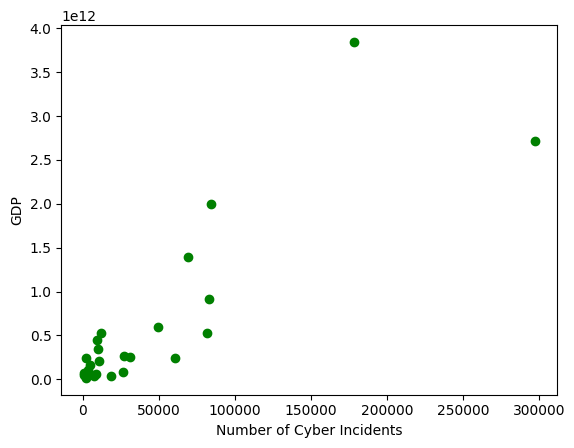

In [44]:
plt.plot(arr_com, arr_gdp, 'o', color = 'g')
plt.xlabel('Number of Cyber Incidents')
plt.ylabel('GDP')

Text(0, 0.5, 'Population')

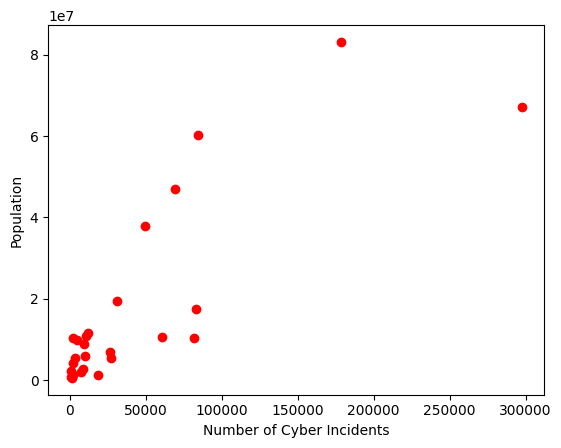

In [45]:
plt.plot(arr_com, arr_pop, 'o', color = 'r')
plt.xlabel('Number of Cyber Incidents')
plt.ylabel('Population')